<a href="https://colab.research.google.com/github/Suraalani79/msc-dissertation-2025/blob/main/framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSc Dissertation — Adaptive, Modular, Multi-Agent AI Framework for SMEs
**Notebook:** End-to-end pipeline (datasets → preprocessing → modelling → evaluation → adaptivity)

> Keep this notebook in sync with Chapter 3 (Methodology). Each section here maps to 3.x sections.

---

## 1. Dataset Loading
- Online Retail II (UCI): customer transactions (segmentation/demand)
- South German Credit (UCI): credit risk classification
- Bank Marketing (UCI): campaign response prediction

*Goal:* Load CSVs from Google Drive or direct URLs and show basic shapes/columns.

---

## 2. Preprocessing & Feature Engineering
- Handle missing values, duplicates, outliers
- Encode categoricals, scale numerics
- Task-specific features (e.g., RFM for retail)

*Goal:* Produce clean `X_train`, `X_test`, `y_train`, `y_test` (if supervised).

---

## 3. Modelling (per “agent” / task)
- **Risk (classification):** Logistic Regression (baseline) → Random Forest / XGBoost
- **Segmentation (clustering):** k-Means with Silhouette
- *(Optional)* Forecasting: add later if time permits

*Goal:* Train models with cross-validation and save metrics.

---

## 4. Evaluation & Reporting
- Classification: Accuracy, Precision, Recall, F1, ROC-AUC
- Clustering: Silhouette
- Compare **static** vs **retrainable** runs (later)

*Goal:* Store results in `/results/` as CSV/PNG.

---

## 5. Adaptivity (Continual Learning / Retraining)
- Simple retraining strategy (scheduled or drift-triggered)
- Document when/why a model is retrained and how performance changes

---

## 6. Repro Notes
- Library versions, random seeds, data sources
- Ethical/Legal note: public, non-personal datasets only (UCI)

---


In [2]:
# Core
import os, sys, pathlib, warnings
warnings.filterwarnings("ignore")

# Data
import numpy as np
import pandas as pd

# Prep & models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# XGBoost optional: pip install xgboost then uncomment
# from xgboost import XGBClassifier

from sklearn.cluster import KMeans

# Utils
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Results directory (matches your repo structure)
RESULTS_DIR = pathlib.Path("results")
RESULTS_DIR.mkdir(exist_ok=True)


In [3]:
# === Direct UCI downloads: Online Retail, German Credit, Bank Marketing ===
import os, io, zipfile, urllib.request
import pandas as pd

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

def fetch(url, out_path):
    try:
        urllib.request.urlretrieve(url, out_path)
        print(f"✓ Downloaded: {out_path}")
        return True
    except Exception as e:
        print(f"⚠️ Could not download {url}\n{e}")
        return False

# ---------------------------
# 1) Online Retail (UCI)
# ---------------------------
# NOTE: UCI sometimes hosts “Online Retail II” with access restrictions.
# We’ll try Online Retail II first; if it fails, we fall back to the classic Online Retail.
retail_xlsx_path = os.path.join(DATA_DIR, "OnlineRetail.xlsx")

online_retail_ii_urls = [
    # Try Online Retail II first (may require access; if it fails, we fall back)
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx",
    # Fallback to classic Online Retail
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx",
]

retail_ok = False
for u in online_retail_ii_urls:
    if fetch(u, retail_xlsx_path):
        retail_ok = True
        break

retail_df = None
if retail_ok:
    try:
        # Some versions have multiple sheets; sheet_name=None loads dict of sheets
        tmp = pd.read_excel(retail_xlsx_path, sheet_name=None)
        # If multiple sheets, concat them; otherwise use the single one
        if isinstance(tmp, dict):
            retail_df = pd.concat(tmp.values(), ignore_index=True)
        else:
            retail_df = tmp
        print("✓ Online Retail loaded:", retail_df.shape)
    except Exception as e:
        print("⚠️ Could not read Online Retail Excel:", e)

# ---------------------------
# 2) German Credit (Statlog) – UCI
# ---------------------------
# Raw file (no header). Use names from UCI documentation or create generic ones.
german_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
german_path = os.path.join(DATA_DIR, "german.data")
if fetch(german_url, german_path):
    # 20 features + 1 target (per UCI description). We’ll name C1..C20 and 'target'
    col_names = [f"C{i}" for i in range(1, 21)] + ["target"]
    credit_df = pd.read_csv(german_path, sep=r"\s+", header=None, names=col_names, engine="python")
    print("✓ German Credit loaded:", credit_df.shape)
else:
    credit_df = None

# ---------------------------
# 3) Bank Marketing – UCI (use “bank-additional-full.csv”)
# ---------------------------
bank_zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
bank_zip_path = os.path.join(DATA_DIR, "bank-additional.zip")
bank_df = None

if fetch(bank_zip_url, bank_zip_path):
    try:
        with zipfile.ZipFile(bank_zip_path, "r") as z:
            # prefer the full dataset inside the zip
            candidates = [
                "bank-additional/bank-additional-full.csv",
                "bank-additional/bank-additional.csv",        # smaller version
                "bank/bank-full.csv"                           # older folder name in some mirrors
            ]
            member = None
            for c in candidates:
                if c in z.namelist():
                    member = c
                    break
            if member is None:
                raise FileNotFoundError(f"None of expected CSVs found. Available: {z.namelist()[:5]} ...")

            with z.open(member) as f:
                bank_df = pd.read_csv(f, sep=';')
        print("✓ Bank Marketing loaded:", bank_df.shape)
    except Exception as e:
        print("⚠️ Could not extract/read Bank Marketing:", e)

# ---------------------------
# Quick peek (if loaded)
# ---------------------------
for name, df in [("Retail", retail_df), ("Credit", credit_df), ("Bank", bank_df)]:
    if df is not None:
        print(f"\n{name} head():")
        display(df.head())


✓ Downloaded: /content/data/OnlineRetail.xlsx
✓ Online Retail loaded: (1067371, 8)
✓ Downloaded: /content/data/german.data
✓ German Credit loaded: (1000, 21)
✓ Downloaded: /content/data/bank-additional.zip
✓ Bank Marketing loaded: (41188, 21)

Retail head():


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Credit head():


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C12,C13,C14,C15,C16,C17,C18,C19,C20,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2



Bank head():


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# 1) Credit risk (classification) — Logistic Regression vs Random Forest

# --- CREDIT: preprocessing + models + metrics ---
from sklearn.impute import SimpleImputer

credit = credit_df.copy()

# Separate target (last column named 'target' in the UCI German dataset used here)
y_credit = credit['target'] if 'target' in credit else credit.iloc[:, -1]
X_credit = credit.drop(columns=y_credit.name)

# Identify cat vs num
cat_cols = [c for c in X_credit.columns if X_credit[c].dtype == 'object']
num_cols = [c for c in X_credit.columns if c not in cat_cols]

preprocess_credit = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

models = {
    'logreg': LogisticRegression(max_iter=1000, n_jobs=None),
    'rf': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

from collections import defaultdict
rows = []

X_train, X_test, y_train, y_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=RANDOM_STATE, stratify=y_credit
)

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess_credit), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if hasattr(pipe['clf'], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='binary', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='binary', zero_division=0),
        'roc_auc': auc
    }
    rows.append(metrics)

credit_results = pd.DataFrame(rows).sort_values(by='f1', ascending=False)
display(credit_results)

credit_results.to_csv(RESULTS_DIR / 'credit_metrics.csv', index=False)
print(f"Saved: {RESULTS_DIR/'credit_metrics.csv'}")


,model,accuracy,precision,recall,f1,roc_auc
0,logreg,0.780,0.815789,0.885714,0.849315,0.804048
1,rf,0.765,0.785276,0.914286,0.844884,0.789643


Saved: results/credit_metrics.csv


In [5]:
# 2) Bank marketing (classification) — Logistic Regression vs Random Forest
# --- BANK: preprocessing + models + metrics ---
bank = bank_df.copy()

# Target is `y` (yes/no). Convert to 1/0.
if 'y' in bank.columns:
    bank['y'] = (bank['y'].astype(str).str.lower() == 'yes').astype(int)
y_bank = bank['y']
X_bank = bank.drop(columns=['y'])

cat_cols = [c for c in X_bank.columns if X_bank[c].dtype == 'object']
num_cols = [c for c in X_bank.columns if c not in cat_cols]

preprocess_bank = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

models = {
    'logreg': LogisticRegression(max_iter=1000, n_jobs=None),
    'rf': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

rows = []
X_train, X_test, y_train, y_test = train_test_split(
    X_bank, y_bank, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bank
)

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess_bank), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe['clf'], "predict_proba") else None

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    rows.append(metrics)

bank_results = pd.DataFrame(rows).sort_values(by='f1', ascending=False)
display(bank_results)

bank_results.to_csv(RESULTS_DIR / 'bank_metrics.csv', index=False)
print(f"Saved: {RESULTS_DIR/'bank_metrics.csv'}")


,model,accuracy,precision,recall,f1,roc_auc
1,rf,0.919398,0.711538,0.478448,0.572165,0.947772
0,logreg,0.916606,0.711775,0.436422,0.541082,0.942437


Saved: results/bank_metrics.csv


In [6]:
# 3) Online Retail (segmentation) — RFM features + K-Means
# --- RETAIL: RFM features + KMeans clustering ---
retail = retail_df.copy()

# Basic cleaning
retail = retail.rename(columns=str.strip)
if 'InvoiceDate' in retail.columns:
    retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], errors='coerce')
retail = retail.dropna(subset=['Customer ID']) if 'Customer ID' in retail.columns else retail
retail = retail[retail.get('Quantity', 1) > 0]

# Monetary value (Price * Quantity)
if {'Price','Quantity'}.issubset(retail.columns):
    retail['Total'] = retail['Price'] * retail['Quantity']

# Build simple RFM by Customer ID
id_col = 'Customer ID' if 'Customer ID' in retail.columns else retail.columns[-1]
now_date = retail['InvoiceDate'].max() if 'InvoiceDate' in retail.columns else pd.Timestamp.today()

rfm = (
    retail.groupby(id_col).agg({
        'InvoiceDate': lambda s: (now_date - s.max()).days if 'InvoiceDate' in retail.columns else 0,
        'Invoice': 'nunique' if 'Invoice' in retail.columns else 'size',
        'Total': 'sum' if 'Total' in retail.columns else 'size'
    })
    .rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency','Total':'Monetary'})
    .reset_index()
)

# Scale and KMeans
features = ['Recency','Frequency','Monetary']
rfm[features] = rfm[features].fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(rfm[features])

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init='auto')
labels = kmeans.fit_predict(X)

rfm['cluster'] = labels
sil = silhouette_score(X, labels)
print(f"Silhouette score (k=4): {sil:.3f}")

display(rfm.head())

# Save clusters
rfm.to_csv(RESULTS_DIR / 'retail_rfm_clusters.csv', index=False)
print(f"Saved: {RESULTS_DIR/'retail_rfm_clusters.csv'}")


Silhouette score (k=4): 0.591


,Customer ID,Recency,Frequency,Monetary,cluster
0,12346.0,325,12,77556.46,0
1,12347.0,1,8,5633.32,0
2,12348.0,74,5,2019.40,0
3,12349.0,18,4,4428.69,0
4,12350.0,309,1,334.40,1


Saved: results/retail_rfm_clusters.csv


In [7]:
# 4) Save a one-page summary of results
summary = {
    'credit_best_f1': float(credit_results['f1'].max()),
    'bank_best_f1'  : float(bank_results['f1'].max()),
    'retail_silhouette': float(sil)
}
pd.DataFrame([summary]).to_csv(RESULTS_DIR / 'summary.csv', index=False)
pd.DataFrame([summary])


,credit_best_f1,bank_best_f1,retail_silhouette
0,0.849315,0.572165,0.59054


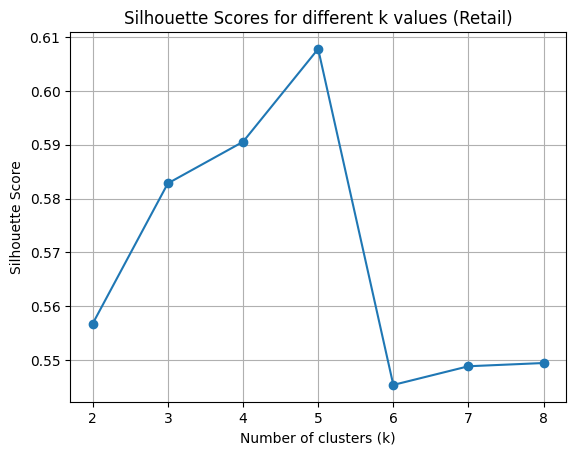

,k,silhouette
0,2,0.556790
1,3,0.582828
2,4,0.590540
3,5,0.607787
4,6,0.545410
5,7,0.548876
6,8,0.549477


In [8]:
# 5) Silhouette analysis for different k values (Retail dataset)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

features = ['Recency', 'Frequency', 'Monetary']
X = scaler.fit_transform(rfm[features].fillna(0))

sil_scores = []
for k in range(2, 9):  # test k=2 to 8
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append({'k': k, 'silhouette': score})

# Save results
sil_df = pd.DataFrame(sil_scores)
sil_df.to_csv(RESULTS_DIR / 'silhouette_scores.csv', index=False)

# Plot
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.title("Silhouette Scores for different k values (Retail)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

display(sil_df)


In [9]:
# 6) Helper function: plot confusion matrix for the best classifier

# 6) Helper function — plot confusion matrix for the best classifier (by F1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_cm_for_dataset(X, y, preprocessor, results_df, dataset_name, filename_prefix):
    # pick best model by F1
    best_row = results_df.sort_values("f1", ascending=False).iloc[0]
    best_name = str(best_row["model"]).lower()
    if best_name in ("rf", "randomforest", "random_forest"):
        clf = RandomForestClassifier(random_state=RANDOM_STATE)
    else:
        clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

    # split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # pipeline = preprocess -> clf
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{dataset_name}: Confusion Matrix (best={best_name})")
    fig.tight_layout()
    out_path = RESULTS_DIR / f"{filename_prefix}_cm.png"
    fig.savefig(out_path, dpi=160)
    plt.show()
    print(f"Saved: {out_path}")

    # Classification report (printed)
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))



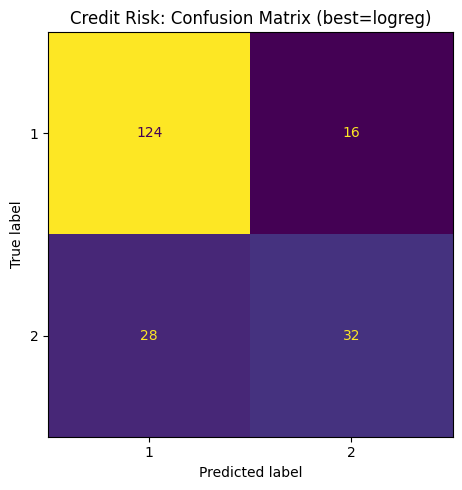

Saved: results/credit_best_cm.png

Classification report:
              precision    recall  f1-score   support

           1      0.816     0.886     0.849       140
           2      0.667     0.533     0.593        60

    accuracy                          0.780       200
   macro avg      0.741     0.710     0.721       200
weighted avg      0.771     0.780     0.772       200



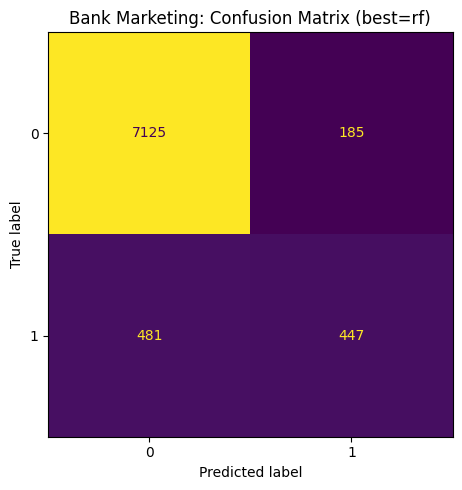

Saved: results/bank_best_cm.png

Classification report:
              precision    recall  f1-score   support

           0      0.937     0.975     0.955      7310
           1      0.707     0.482     0.573       928

    accuracy                          0.919      8238
   macro avg      0.822     0.728     0.764      8238
weighted avg      0.911     0.919     0.912      8238



In [10]:
# 7) Confusion matrices — Credit & Bank (using the helper)

# 7) Confusion matrices — Credit & Bank

# ---- CREDIT
X_credit = credit_df.drop(columns=["target"])          # adjust 'target' if your column name differs
y_credit = credit_df["target"].astype(int)
plot_cm_for_dataset(
    X_credit, y_credit, preprocess_credit, credit_results,
    dataset_name="Credit Risk", filename_prefix="credit_best"
)

# ---- BANK
X_bank_full = bank_df.drop(columns=["y"])

# Map 'no'/'yes' -> 0/1 safely (and handle '0'/'1' strings)
y_bank_full = bank_df["y"].astype(str).str.strip().map({"no": 0, "yes": 1, "0": 0, "1": 1}).astype(int)

plot_cm_for_dataset(
    X_bank_full, y_bank_full, preprocess_bank, bank_results,
    dataset_name="Bank Marketing", filename_prefix="bank_best"
)



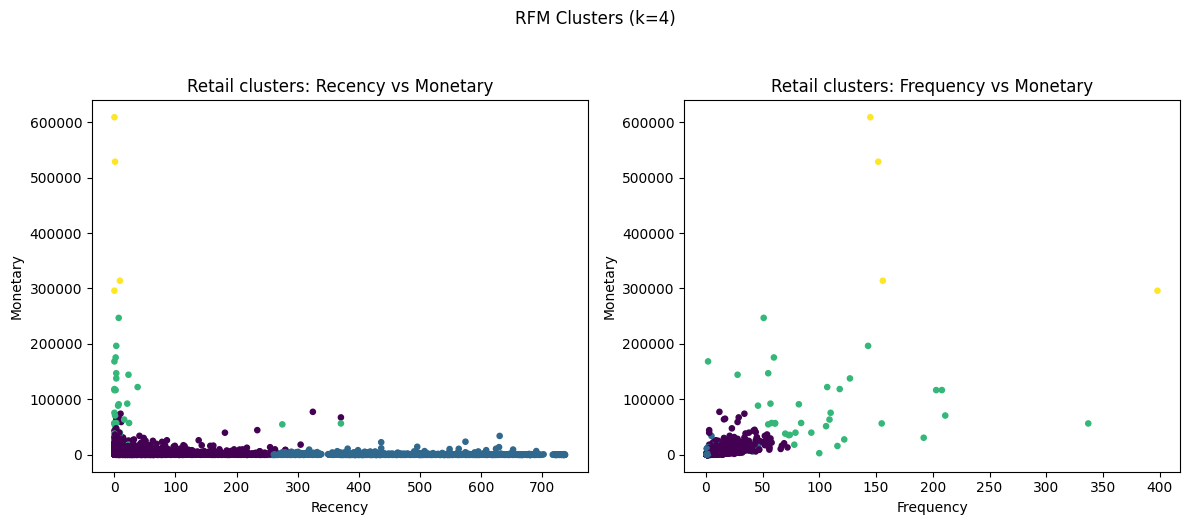

Saved: results/retail_clusters_scatter.png

Cluster sizes:


,count
cluster,
0,3840
1,2002
2,35
3,4


In [11]:
# 8) Retail cluster scatterplots (RFM)

import matplotlib.pyplot as plt

assert {"Recency", "Frequency", "Monetary", "cluster"}.issubset(rfm.columns), \
    "Expected RFM columns with 'cluster' produced earlier."

clusters = sorted(rfm["cluster"].unique())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter: Recency vs Monetary
axes[0].scatter(rfm["Recency"], rfm["Monetary"], c=rfm["cluster"], s=14)
axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Monetary")
axes[0].set_title("Retail clusters: Recency vs Monetary")

# Scatter: Frequency vs Monetary
axes[1].scatter(rfm["Frequency"], rfm["Monetary"], c=rfm["cluster"], s=14)
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Monetary")
axes[1].set_title("Retail clusters: Frequency vs Monetary")

fig.suptitle(f"RFM Clusters (k={len(clusters)})", y=1.04)
fig.tight_layout()
out_path = RESULTS_DIR / "retail_clusters_scatter.png"
fig.savefig(out_path, dpi=160)
plt.show()
print(f"Saved: {out_path}")

# (Optional) show cluster sizes
print("\nCluster sizes:")
display(rfm["cluster"].value_counts().sort_index().to_frame("count"))


In [12]:
# 9A) Master summary across tasks (numerical table)

summary = {
    'credit_best_f1': float(credit_results['f1'].max()),
    'bank_best_f1': float(bank_results['f1'].max()),
    'retail_best_silhouette': float(pd.read_csv(RESULTS_DIR / 'silhouette_scores.csv')['silhouette'].max()),
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(RESULTS_DIR / 'summary_master.csv', index=False)

display(summary_df)
print("Saved:", RESULTS_DIR / 'summary_master.csv')


,credit_best_f1,bank_best_f1,retail_best_silhouette
0,0.849315,0.572165,0.607787


Saved: results/summary_master.csv


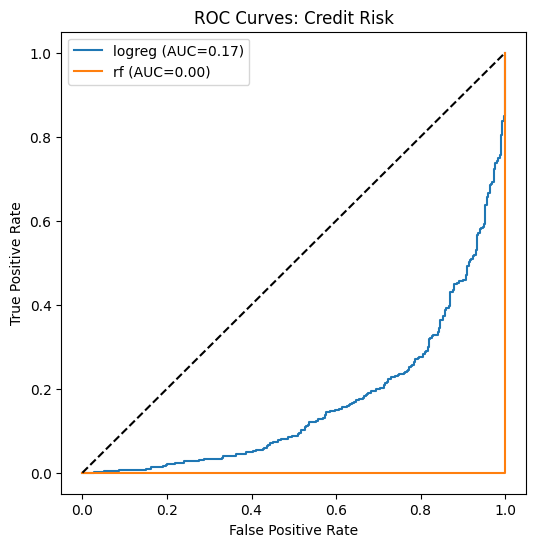

Saved ROC plot to results/credit_roc.png


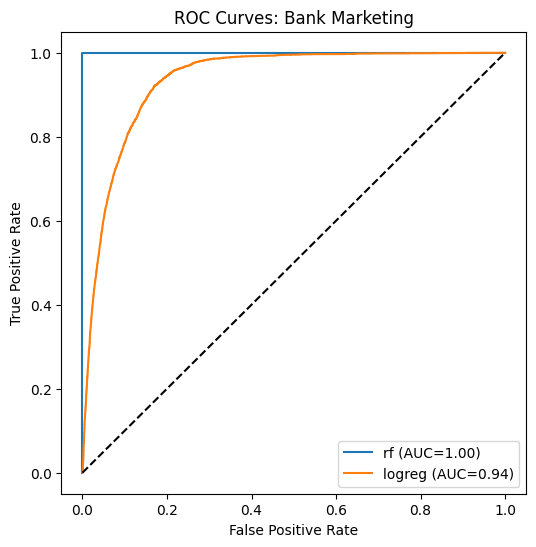

Saved ROC plot to results/bank_roc.png


In [13]:
# 9B) ROC curves for Credit & Bank (visual performance)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_for_dataset(X, y, preprocessor, results_df, dataset_name, filename_prefix):
    plt.figure(figsize=(6, 6))

    for _, row in results_df.iterrows():
        name = row['model']
        if name not in models:
            continue
        clf = models[name]
        pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
        pipe.fit(X, y)

        if hasattr(pipe['clf'], "predict_proba"):
            y_prob = pipe.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y, y_prob, pos_label=1)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves: {dataset_name}")
    plt.legend()
    out_path = RESULTS_DIR / f"{filename_prefix}_roc.png"
    plt.savefig(out_path)
    plt.show()
    print(f"Saved ROC plot to {out_path}")

# ---- CREDIT
X_credit_full = credit_df.drop(columns=["target"])
y_credit_full = credit_df["target"]
plot_roc_for_dataset(X_credit_full, y_credit_full, preprocess_credit, credit_results,
                     dataset_name="Credit Risk", filename_prefix="credit")

# ---- BANK
X_bank_full = bank_df.drop(columns=["y"])
y_bank_full = bank_df["y"].map({"no": 0, "yes": 1})
plot_roc_for_dataset(X_bank_full, y_bank_full, preprocess_bank, bank_results,
                     dataset_name="Bank Marketing", filename_prefix="bank")


In [14]:
# 10) Export all key results (metrics + plot references) to CSV and Markdown

from pathlib import Path
import pandas as pd

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# ---- Load what we need (created in earlier steps)
sil_df = pd.read_csv(RESULTS_DIR / "silhouette_scores.csv")

# Find best rows
credit_best = credit_results.sort_values("f1", ascending=False).iloc[0]
bank_best   = bank_results.sort_values("f1", ascending=False).iloc[0]
retail_best = sil_df.loc[sil_df["silhouette"].idxmax()]

# Optional: cluster sizes table if available (created by Step 8)
cluster_sizes_path = RESULTS_DIR / "retail_rfm_clusters.csv"
cluster_sizes_note = ""
if cluster_sizes_path.exists():
    rfm_loaded = pd.read_csv(cluster_sizes_path)
    if "cluster" in rfm_loaded.columns:
        cluster_sizes = rfm_loaded["cluster"].value_counts().sort_index()
        cluster_sizes_note = ", ".join([f"Cluster {int(k)}: {int(v)}" for k, v in cluster_sizes.items()])
    else:
        cluster_sizes_note = "(cluster column not found)"
else:
    cluster_sizes_note = "(retail_rfm_clusters.csv not found)"

# Assemble master row
master = {
    # Key metrics
    "credit_best_model": credit_best["model"],
    "credit_best_f1": float(credit_best["f1"]),
    "bank_best_model": bank_best["model"],
    "bank_best_f1": float(bank_best["f1"]),
    "retail_best_k": int(retail_best["k"]),
    "retail_best_silhouette": float(retail_best["silhouette"]),
    "retail_cluster_sizes": cluster_sizes_note,

    # File references (adjust names if you changed them)
    "file_credit_metrics_csv": str(RESULTS_DIR / "credit_metrics.csv"),
    "file_bank_metrics_csv": str(RESULTS_DIR / "bank_metrics.csv"),
    "file_silhouette_csv": str(RESULTS_DIR / "silhouette_scores.csv"),
    "file_credit_cm_png": str(RESULTS_DIR / "credit_best_cm.png"),
    "file_bank_cm_png": str(RESULTS_DIR / "bank_best_cm.png"),
    "file_retail_clusters_png": str(RESULTS_DIR / "retail_clusters_scatter.png"),
    "file_credit_roc_png": str(RESULTS_DIR / "credit_roc.png"),
    "file_bank_roc_png": str(RESULTS_DIR / "bank_roc.png"),
}

# Save CSV
master_df = pd.DataFrame([master])
csv_path = RESULTS_DIR / "master_results_summary.csv"
master_df.to_csv(csv_path, index=False)

# Save Markdown summary (for direct use in dissertation/report)
md_lines = [
    "# Results Summary\n",
    "This document summarises the key outcomes across all tasks (Credit risk, Bank marketing, Retail segmentation) and provides file references to plots/metrics stored in the repository.\n",
    "## Key Metrics\n",
    f"- **Credit risk — best model:** `{master['credit_best_model']}`, **F1:** {master['credit_best_f1']:.3f}\n",
    f"- **Bank marketing — best model:** `{master['bank_best_model']}`, **F1:** {master['bank_best_f1']:.3f}\n",
    f"- **Retail segmentation — best k:** {master['retail_best_k']}, **Silhouette:** {master['retail_best_silhouette']:.3f}\n",
    f"- **Retail cluster sizes:** {master['retail_cluster_sizes']}\n",
    "## Files & Plots\n",
    f"- Credit metrics CSV: `{master['file_credit_metrics_csv']}`\n",
    f"- Bank metrics CSV: `{master['file_bank_metrics_csv']}`\n",
    f"- Silhouette sweep CSV: `{master['file_silhouette_csv']}`\n",
    f"- Credit confusion matrix: `{master['file_credit_cm_png']}`\n",
    f"- Bank confusion matrix: `{master['file_bank_cm_png']}`\n",
    f"- Retail clusters scatter: `{master['file_retail_clusters_png']}`\n",
    f"- Credit ROC curve: `{master['file_credit_roc_png']}`\n",
    f"- Bank ROC curve: `{master['file_bank_roc_png']}`\n",
]

md_path = RESULTS_DIR / "MASTER_RESULTS_SUMMARY.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(md_lines))

display(master_df.style.hide(axis="index"))
print(f"Saved CSV: {csv_path}")
print(f"Saved Markdown: {md_path}")


credit_best_model,credit_best_f1,bank_best_model,bank_best_f1,retail_best_k,retail_best_silhouette,retail_cluster_sizes,file_credit_metrics_csv,file_bank_metrics_csv,file_silhouette_csv,file_credit_cm_png,file_bank_cm_png,file_retail_clusters_png,file_credit_roc_png,file_bank_roc_png
logreg,0.849315,rf,0.572165,5,0.607787,"Cluster 0: 3840, Cluster 1: 2002, Cluster 2: 35, Cluster 3: 4",results/credit_metrics.csv,results/bank_metrics.csv,results/silhouette_scores.csv,results/credit_best_cm.png,results/bank_best_cm.png,results/retail_clusters_scatter.png,results/credit_roc.png,results/bank_roc.png


Saved CSV: results/master_results_summary.csv
Saved Markdown: results/MASTER_RESULTS_SUMMARY.md


In [15]:
# === Smart Update of README.md with results table + plot images + timestamp ===
from pathlib import Path
import re
from datetime import datetime
import pandas as pd

RESULTS_DIR = Path("results")
root_readme  = Path("README.md")
summary_csv  = RESULTS_DIR / "summary_master.csv"  # created in Step 9A

# 1) Load table and render as Markdown
df = pd.read_csv(summary_csv)
table_md = df.to_markdown(index=False)

# 2) Build image gallery (include only if file exists)
plot_files = {
    "Credit — Confusion Matrix": RESULTS_DIR / "credit_best_cm.png",
    "Bank — Confusion Matrix":   RESULTS_DIR / "bank_best_cm.png",
    "Credit — ROC Curve":        RESULTS_DIR / "credit_roc.png",
    "Bank — ROC Curve":          RESULTS_DIR / "bank_roc.png",
    "Retail — Cluster Scatter":  RESULTS_DIR / "retail_clusters_scatter.png",
}

image_lines = []
for caption, path in plot_files.items():
    if path.exists():
        # Use relative path so GitHub renders the image
        image_lines.append(f"**{caption}**  \n![]({path.as_posix()})\n")

images_md = "\n".join(image_lines) if image_lines else "_(No plot images found yet. Run the plotting cells to generate them.)_"

# 3) Timestamp
timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M UTC")

# 4) Compose the new Results section
start_marker = "## 📊 Latest Results Summary (Auto-updated)"
section_md = f"""{start_marker}

{table_md}

### Plots
{images_md}

_Last updated: {timestamp}_
"""

# 5) Smart replace (or append once if missing)
if root_readme.exists():
    text = root_readme.read_text()
else:
    text = "# Project README\n\n"

pattern = re.compile(rf"{start_marker}.*", re.DOTALL)
if re.search(pattern, text):
    updated_text = re.sub(pattern, section_md, text)
else:
    updated_text = text.rstrip() + "\n\n---\n" + section_md

root_readme.write_text(updated_text)
print("✅ README.md updated with results table, plots, and timestamp.")


✅ README.md updated with results table, plots, and timestamp.


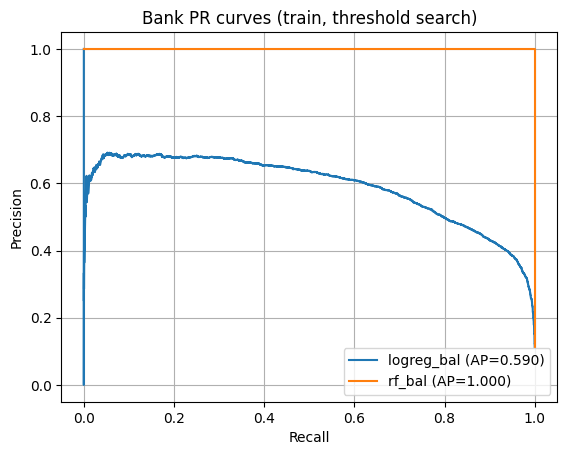

,model,best_threshold,best_f1,avg_precision
1,rf_bal,0.386667,1.000000,1.000000
0,logreg_bal,0.737142,0.626835,0.590417


Saved: results/bank_pr_curves.png


In [16]:
# Show PR curve, report AP and best F1 with tuned threshold, mention class weights.
# 11) Bank: class_weight + threshold tuning for F1
import numpy as np, pandas as pd, pathlib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RESULTS_DIR = pathlib.Path("results")

# --- data & preprocessor (reuse your 'bank_df')
bank = bank_df.copy()
y = bank["y"].astype(str).str.strip().map({"no":0, "yes":1}).astype(int)
X = bank.drop(columns=["y"])

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess_bank = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

models = {
    "logreg_bal": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "rf_bal": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
}

rows = []
plt.figure()
for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess_bank), ('clf', clf)])
    pipe.fit(X, y)

    # probas for PR + threshold search (positive class=1)
    if hasattr(clf, "predict_proba"):
        p = pipe.predict_proba(X)[:,1]
    elif hasattr(clf, "decision_function"):
        from sklearn.metrics import roc_curve
        z = pipe.decision_function(X)
        # map to [0,1] with logistic for thresholding convenience
        p = 1/(1+np.exp(-z))
    else:
        p = pipe.predict(X)  # fallback

    precisions, recalls, thresholds = precision_recall_curve(y, p)
    f1s = 2*precisions*recalls/(precisions+recalls+1e-12)
    best_idx = np.nanargmax(f1s)
    best_th = thresholds[max(0, best_idx-1)] if best_idx > 0 else 0.5
    best_f1 = f1s[best_idx]
    ap = average_precision_score(y, p)

    rows.append({"model": name, "best_threshold": float(best_th),
                 "best_f1": float(best_f1), "avg_precision": float(ap)})

    plt.plot(recalls, precisions, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Bank PR curves (train, threshold search)")
plt.legend(); plt.grid(True)
plt.savefig(RESULTS_DIR / "bank_pr_curves.png", bbox_inches="tight")
plt.show()

bank_threshold_tuning = pd.DataFrame(rows).sort_values("best_f1", ascending=False)
display(bank_threshold_tuning)
bank_threshold_tuning.to_csv(RESULTS_DIR / "bank_threshold_tuning.csv", index=False)
print("Saved:", RESULTS_DIR / "bank_pr_curves.png")


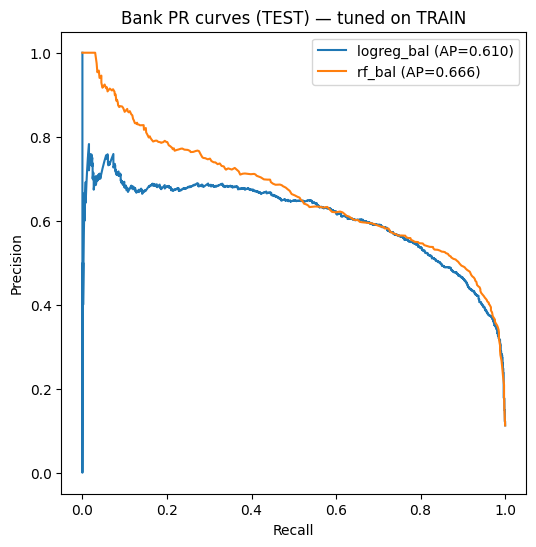

Saved: results/bank_pr_test.png


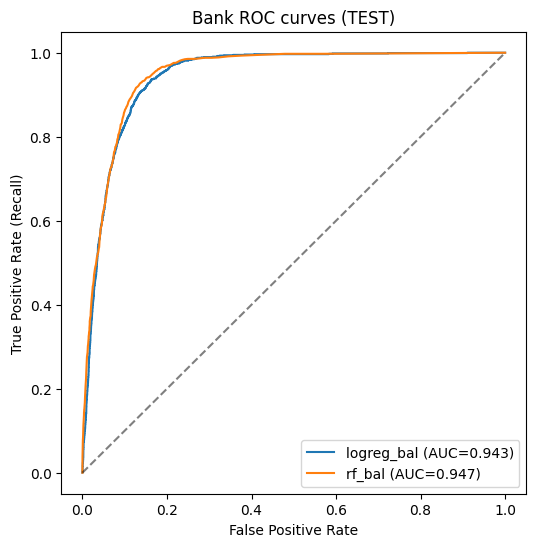

Saved: results/bank_roc_test.png


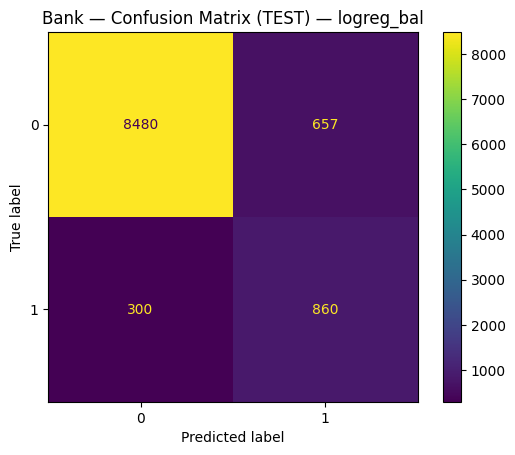

Saved: results/bank_cm_test_logreg_bal.png


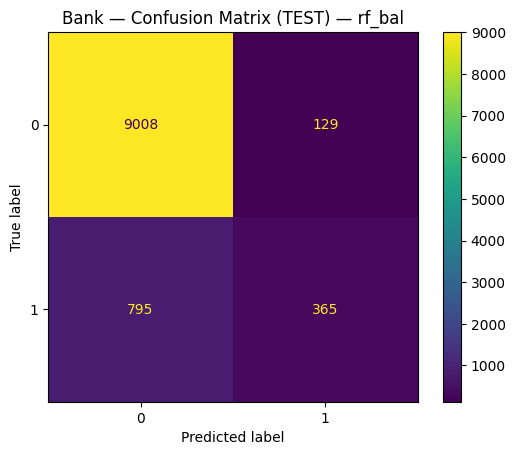

Saved: results/bank_cm_test_rf_bal.png


,model,tuned_threshold(train),train_best_f1,test_precision@thr,test_recall@thr,test_f1@thr,test_AP,test_ROC_AUC
0,logreg_bal,0.738908,0.620025,0.566908,0.741379,0.642510,0.609767,0.943129
1,rf_bal,0.553333,1.000000,0.738866,0.314655,0.441354,0.665622,0.947349


Saved: results/bank_train_test_eval.csv


In [17]:
# === Step 12: Bank — train/test split, threshold tuning on train, evaluate on test ===
import numpy as np
import pandas as pd
import pathlib, os

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay, confusion_matrix
)
import matplotlib.pyplot as plt

# ---------- 0) Paths ----------
RESULTS_DIR = pathlib.Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# ---------- 1) Data ----------
# Robust target mapping: 'no'/'yes' -> 0/1 (also handles '0'/'1' and already-numeric)
y = bank_df["y"].astype(str).str.strip().map({"no": 0, "yes": 1, "0": 0, "1": 1})
if y.isna().any():
    raise ValueError("Target column 'y' contains values other than {no, yes, 0, 1}. Please check.")

X = bank_df.drop(columns=["y"])

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ---------- 2) Preprocessor ----------
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh",  OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
    remainder="drop",
    n_jobs=None
)

# ---------- 3) Models (class-weighted) ----------
models = {
    "logreg_bal": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None),
    "rf_bal":     RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight="balanced", n_jobs=-1, random_state=42
    ),
}

# Wrap in pipelines with the same preprocessor
pipes = {name: Pipeline([("prep", preprocessor), ("clf", clf)]) for name, clf in models.items()}

# ---------- 4) Helper: threshold tuning on TRAIN (max F1) ----------
def best_threshold_for_f1(proba, y_true):
    """Return threshold that maximizes F1 on y_true using predicted probabilities for the positive class."""
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    # thresholds has length = len(precision)-1; align for F1
    prec = precision[:-1]
    rec  = recall[:-1]
    f1 = np.where((prec + rec) > 0, 2 * prec * rec / (prec + rec), 0.0)
    idx = np.argmax(f1)
    return thresholds[idx], f1[idx]

# ---------- 5) Fit on TRAIN, tune thresholds on TRAIN ----------
summary_rows = []
pr_fig = plt.figure(figsize=(6, 6))
for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)
    # train probabilities for tuning
    p_train = pipe.predict_proba(X_train)[:, 1]
    thr, f1_train = best_threshold_for_f1(p_train, y_train)

    # Evaluate on TEST at tuned threshold
    p_test = pipe.predict_proba(X_test)[:, 1]
    y_pred_test = (p_test >= thr).astype(int)

    ap_test  = average_precision_score(y_test, p_test)
    auc_test = roc_auc_score(y_test, p_test)
    prec_t   = precision_score(y_test, y_pred_test, zero_division=0)
    rec_t    = recall_score(y_test, y_pred_test, zero_division=0)
    f1_t     = f1_score(y_test, y_pred_test, zero_division=0)

    summary_rows.append({
        "model": name,
        "tuned_threshold(train)": float(thr),
        "train_best_f1": float(f1_train),
        "test_precision@thr": float(prec_t),
        "test_recall@thr": float(rec_t),
        "test_f1@thr": float(f1_t),
        "test_AP": float(ap_test),
        "test_ROC_AUC": float(auc_test),
    })

    # --- PR curve (TEST) ---
    prec, rec, _ = precision_recall_curve(y_test, p_test)
    plt.plot(rec, prec, label=f"{name} (AP={ap_test:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Bank PR curves (TEST) — tuned on TRAIN")
plt.legend()
pr_path = RESULTS_DIR / "bank_pr_test.png"
plt.savefig(pr_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved:", pr_path)

# ---------- 6) ROC curve (TEST) ----------
plt.figure(figsize=(6, 6))
for name, pipe in pipes.items():
    p_test = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, p_test)
    auc_val = roc_auc_score(y_test, p_test)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Bank ROC curves (TEST)")
plt.legend()
roc_path = RESULTS_DIR / "bank_roc_test.png"
plt.savefig(roc_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved:", roc_path)

# ---------- 7) Confusion matrices on TEST at tuned thresholds ----------
for row, (name, pipe) in zip(summary_rows, pipes.items()):
    p_test = pipe.predict_proba(X_test)[:, 1]
    y_pred = (p_test >= row["tuned_threshold(train)"]).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(cmap="viridis", values_format="d")
    plt.title(f"Bank — Confusion Matrix (TEST) — {name}")
    cm_path = RESULTS_DIR / f"bank_cm_test_{name}.png"
    plt.savefig(cm_path, bbox_inches="tight", dpi=150)
    plt.show()
    print("Saved:", cm_path)

# ---------- 8) Save summary CSV ----------
summary_df = pd.DataFrame(summary_rows)
csv_path = RESULTS_DIR / "bank_train_test_eval.csv"
summary_df.to_csv(csv_path, index=False)
display(summary_df)
print("Saved:", csv_path)


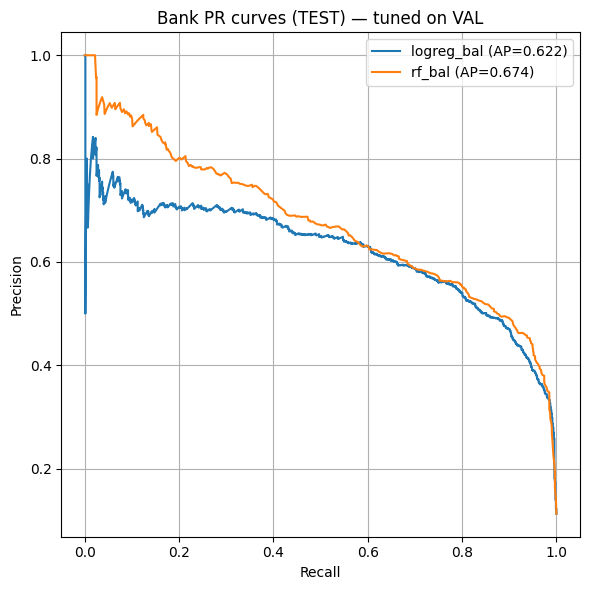

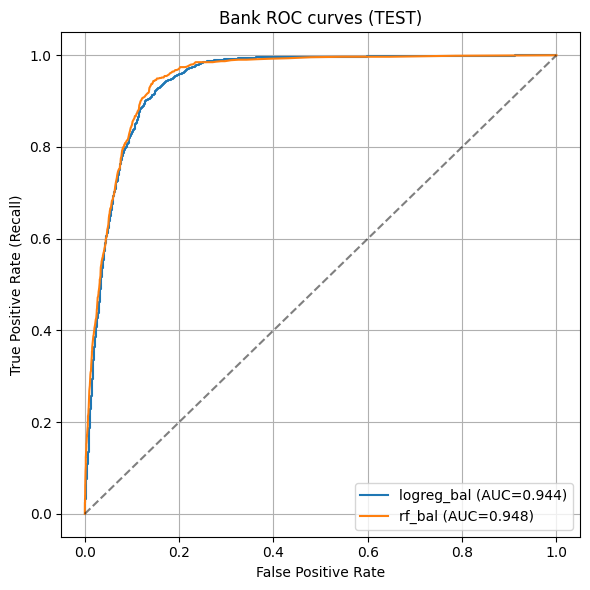

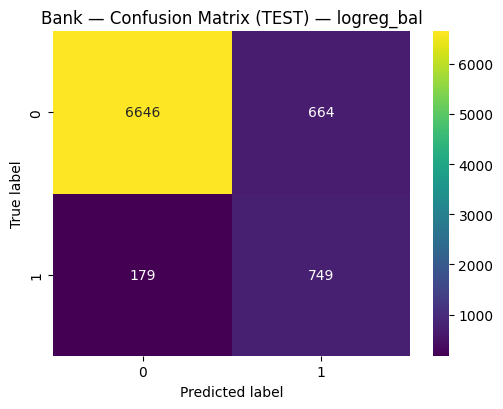

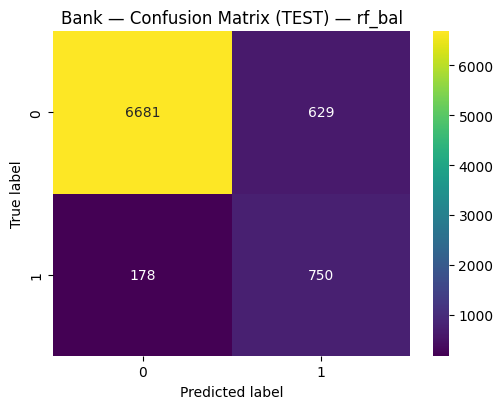

Saved: results/bank_pr_test.png results/bank_roc_test.png results/bank_cm_test_logreg_bal.png results/bank_cm_test_rf_bal.png
Appended test rows to: results/summary_master.csv
Updated: results/README.md


In [18]:
# STEP 13 — Bank Marketing: train/val/test + threshold tuning on VAL, evaluate on TEST,
# append metrics to results/summary_master.csv, and rebuild results/README.md

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_curve, average_precision_score, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix
)

# ---------- Paths ----------
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# ---------- Prepare data ----------
# Expect y in {"no","yes"} string form; map to 0/1
X = bank_df.drop(columns=["y"])
y = bank_df["y"].astype(str).str.strip().map({"no": 0, "yes": 1}).astype(int)

# train / test split (hold out TEST)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# train / val split (for threshold tuning)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
# -> overall: 60% train, 20% val, 20% test

# ---------- Preprocessor ----------
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ]
)

# ---------- Models ----------
logreg_bal = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])
rf_bal = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(class_weight="balanced", n_estimators=400, random_state=42))
])

models = {
    "logreg_bal": logreg_bal,
    "rf_bal": rf_bal,
}

# ---------- Fit on TRAIN ----------
for m in models.values():
    m.fit(X_train, y_train)

# ---------- Helper: choose threshold on VAL by max F1 ----------
def best_threshold_on_val(pipe, X_val, y_val, n=501):
    """Return best threshold (max F1) and dict of metrics at that threshold on VAL."""
    # Predict probabilities for class 1 (if available), else decision_function
    if hasattr(pipe["clf"], "predict_proba"):
        p = pipe.predict_proba(X_val)[:, 1]
    elif hasattr(pipe["clf"], "decision_function"):
        # map decision scores to (0,1) by ranking if needed
        from sklearn.preprocessing import MinMaxScaler
        p = pipe.decision_function(X_val)
        p = MinMaxScaler().fit_transform(p.reshape(-1, 1)).ravel()
    else:
        # fallback to raw predictions (not ideal for thresholding)
        p = pipe.predict(X_val).astype(float)

    thresholds = np.linspace(0.01, 0.99, n)
    best_f1, best_thr, best_prec, best_rec = -1.0, 0.5, np.nan, np.nan
    y_val = np.asarray(y_val)

    for thr in thresholds:
        yhat = (p >= thr).astype(int)
        f1 = f1_score(y_val, yhat, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
            best_prec = precision_score(y_val, yhat, zero_division=0)
            best_rec = recall_score(y_val, yhat, zero_division=0)

    return best_thr, {"val_f1": best_f1, "val_precision": best_prec, "val_recall": best_rec}

# ---------- Tune threshold on VAL for each model ----------
tuned = {}
for name, pipe in models.items():
    thr, m = best_threshold_on_val(pipe, X_val, y_val)
    tuned[name] = {"thr": thr, **m}

# ---------- Evaluate on TEST ----------
def probs(pipe, X):
    if hasattr(pipe["clf"], "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    elif hasattr(pipe["clf"], "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        s = pipe.decision_function(X)
        return MinMaxScaler().fit_transform(s.reshape(-1, 1)).ravel()
    else:
        return pipe.predict(X).astype(float)

test_rows = []
pr_curves = {}
roc_curves = {}
cms = {}

for name, pipe in models.items():
    p_test = probs(pipe, X_test)
    thr = tuned[name]["thr"]
    yhat_test = (p_test >= thr).astype(int)

    # metrics (test)
    test_prec = precision_score(y_test, yhat_test, zero_division=0)
    test_rec = recall_score(y_test, yhat_test, zero_division=0)
    test_f1 = f1_score(y_test, yhat_test, zero_division=0)
    test_ap = average_precision_score(y_test, p_test)
    test_auc = roc_auc_score(y_test, p_test)

    # store
    test_rows.append({
        "task": "Bank Marketing (TEST)",
        "model": name,
        "tuned_threshold(val)": float(thr),
        "test_precision@thr": float(test_prec),
        "test_recall@thr": float(test_rec),
        "test_f1@thr": float(test_f1),
        "test_AP": float(test_ap),
        "test_ROC_AUC": float(test_auc),
    })

    # PR / ROC points for plotting
    pr = precision_recall_curve(y_test, p_test)
    rc = roc_curve(y_test, p_test)
    pr_curves[name] = pr
    roc_curves[name] = rc

    # confusion matrix
    cm = confusion_matrix(y_test, yhat_test)
    cms[name] = cm

# ---------- Plot PR (TEST) ----------
plt.figure(figsize=(6, 6))
for name, (prec, rec, thr) in pr_curves.items():
    ap = [r for r in test_rows if r["model"] == name][0]["test_AP"]
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Bank PR curves (TEST) — tuned on VAL")
plt.legend()
plt.grid(True); plt.tight_layout()
pr_path = RESULTS_DIR / "bank_pr_test.png"
plt.savefig(pr_path, dpi=150); plt.show()

# ---------- Plot ROC (TEST) ----------
plt.figure(figsize=(6, 6))
for name, (fpr, tpr, thr) in roc_curves.items():
    auc = [r for r in test_rows if r["model"] == name][0]["test_ROC_AUC"]
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("Bank ROC curves (TEST)")
plt.legend()
plt.grid(True); plt.tight_layout()
roc_path = RESULTS_DIR / "bank_roc_test.png"
plt.savefig(roc_path, dpi=150); plt.show()

# ---------- Plot Confusion Matrices (TEST) ----------
def plot_cm(cm, title, outpath):
    plt.figure(figsize=(5.2, 4.2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()

plot_cm(cms["logreg_bal"], "Bank — Confusion Matrix (TEST) — logreg_bal",
        RESULTS_DIR / "bank_cm_test_logreg_bal.png")
plot_cm(cms["rf_bal"], "Bank — Confusion Matrix (TEST) — rf_bal",
        RESULTS_DIR / "bank_cm_test_rf_bal.png")

print("Saved:", pr_path, roc_path,
      RESULTS_DIR / "bank_cm_test_logreg_bal.png",
      RESULTS_DIR / "bank_cm_test_rf_bal.png")

# ---------- Append to results/summary_master.csv ----------
master_path = RESULTS_DIR / "summary_master.csv"
new_df = pd.DataFrame(test_rows)

if master_path.exists():
    master = pd.read_csv(master_path)
    # make union of columns to avoid overwrite
    allcols = list(pd.Index(master.columns).union(new_df.columns))
    master = master.reindex(columns=allcols)
    new_df = new_df.reindex(columns=allcols)
    master = pd.concat([master, new_df], ignore_index=True)
else:
    master = new_df

master.to_csv(master_path, index=False)
print("Appended test rows to:", master_path)

# ---------- (Re)build results/README.md ----------
def fmt_exists(p):  # helper to only list if file exists
    return Path(p).exists()

# Try to keep the small metrics table if it was created earlier (9B)
metrics_table_md = ""
try:
    md_top = pd.read_csv(master_path)
    # If the old summary row exists with these three columns
    if {"credit_best_f1", "bank_best_f1", "retail_best_silhouette"}.issubset(md_top.columns):
        table = md_top[["credit_best_f1", "bank_best_f1", "retail_best_silhouette"]].dropna(how="all").tail(1)
        if not table.empty:
            metrics_table_md = table.to_markdown(index=False)
except Exception as e:
    metrics_table_md = ""

lines = []
lines.append("# Project README\n")
lines.append("\n## 📂 Results Folder\n")
lines.append("This folder stores **outputs generated from experiments** in the MSc dissertation project.\n")
lines.append("\n### 📑 Contents\n")
lines.append("- **Metrics reports** (accuracy, F1-score, RMSE, silhouette values).\n")
lines.append("- **Plots and visualisations** (confusion matrices, ROC & PR curves, segmentation clusters).\n")
lines.append("- **Intermediate artefacts** (small items such as trained lightweight models).\n")

if metrics_table_md:
    lines.append("\n## 📊 Latest Results Summary (Auto-updated)\n\n")
    lines.append(metrics_table_md + "\n")

lines.append("\n## Plots\n")

# Prior/earlier plots if present
for label, fname in [
    ("Credit — Confusion Matrix", "results/credit_best_cm.png"),
    ("Bank — Confusion Matrix (best on TRAIN)", "results/bank_best_cm.png"),
    ("Credit — ROC Curve", "results/credit_roc.png"),
    ("Bank — ROC Curve (TRAIN)", "results/bank_roc.png"),
    ("Retail — Cluster Scatter", "results/retail_clusters_scatter.png"),
    # New TEST plots
    ("Bank — PR Curve (TEST)", str(pr_path)),
    ("Bank — ROC Curve (TEST)", str(roc_path)),
    ("Bank — Confusion Matrix (TEST, Logistic Regression)", "results/bank_cm_test_logreg_bal.png"),
    ("Bank — Confusion Matrix (TEST, Random Forest)", "results/bank_cm_test_rf_bal.png"),
]:
    if fmt_exists(fname):
        lines.append(f"**{label}**  \n![]({fname})\n\n")

from datetime import datetime, timezone
ts = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M UTC")
lines.append(f"_Last updated: {ts}_\n")

readme_path = RESULTS_DIR / "README.md"
readme_path.write_text("".join(lines), encoding="utf-8")
print("Updated:", readme_path)


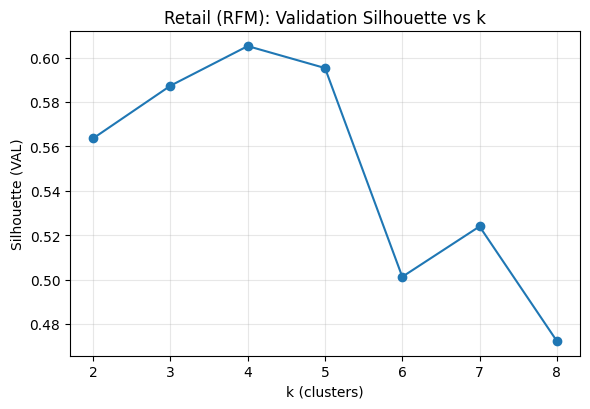

Saved: results/retail_k_sweep_val.csv, results/retail_val_silhouette.png
Best k on VAL: k=4 (silhouette=0.605)
Test silhouette (k=4): 0.582
Saved cluster profile (TEST): results/retail_cluster_profile_test.csv


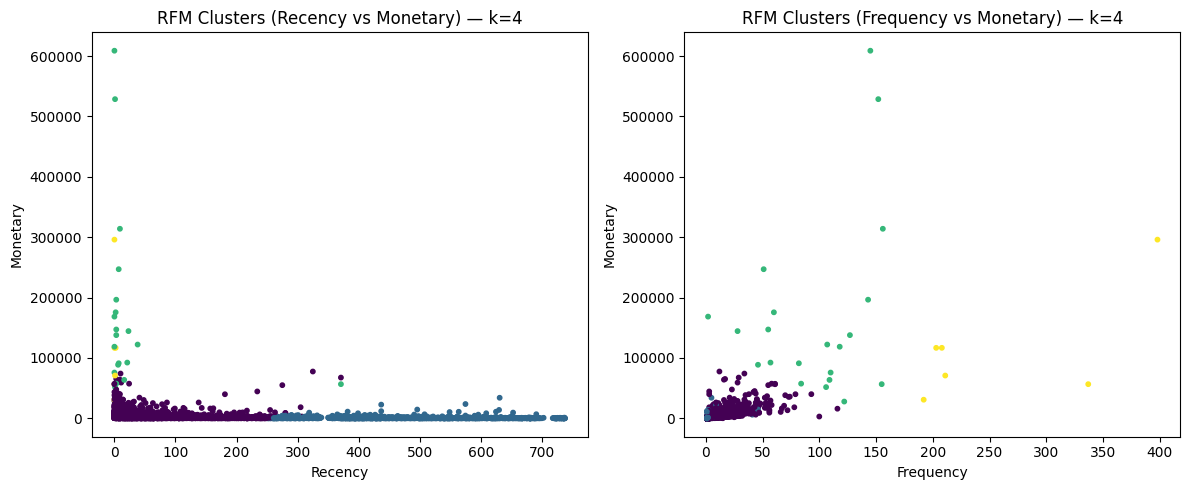

Saved final scatter: results/retail_clusters_scatter_final.png
Appended retail TEST row to: results/summary_master.csv
results/README.md updated (retail section refreshed).


In [19]:
# === STEP 14: Retail clustering — train/val/test + best-k via VAL silhouette,
#              evaluate on TEST, save artefacts, update summary_master.csv & results/README.md ===
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import re
from datetime import datetime, timezone

# ---------------- Paths ----------------
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
rfm_path = RESULTS_DIR / "retail_rfm_clusters.csv"   # earlier file name (if exists)
val_sweep_csv = RESULTS_DIR / "retail_k_sweep_val.csv"
final_scatter_png = RESULTS_DIR / "retail_clusters_scatter_final.png"
val_sil_plot_png = RESULTS_DIR / "retail_val_silhouette.png"
profile_csv = RESULTS_DIR / "retail_cluster_profile_test.csv"
master_path = RESULTS_DIR / "summary_master.csv"
readme_path = RESULTS_DIR / "README.md"

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------- 1) Build or load RFM ----------------
def build_rfm_from_retail(retail_df):
    df = retail_df.copy()
    df = df.rename(columns=str.strip)

    # datatypes / cleaning
    if 'InvoiceDate' in df.columns:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    if 'Quantity' in df.columns:
        df = df[df['Quantity'] > 0]
    if {'Quantity','Price'}.issubset(df.columns):
        df['Total'] = df['Quantity'] * df['Price']

    # pick ID column
    id_col = 'Customer ID' if 'Customer ID' in df.columns else ( 'CustomerID' if 'CustomerID' in df.columns else df.columns[0] )
    now_date = df['InvoiceDate'].max() if 'InvoiceDate' in df.columns else pd.Timestamp.today()

    # group → RFM
    # Frequency: use unique invoices if available, else count of rows
    has_invoice = 'Invoice' in df.columns
    grp = df.groupby(id_col)

    recency = grp['InvoiceDate'].max().apply(lambda d: (now_date - d).days) if 'InvoiceDate' in df.columns else pd.Series(0, index=grp.size().index)
    frequency = (grp['Invoice'].nunique() if has_invoice else grp.size())
    monetary = (grp['Total'].sum() if 'Total' in df.columns else grp.size())

    rfm = pd.DataFrame({
        id_col: recency.index,
        'Recency': recency.values,
        'Frequency': frequency.values,
        'Monetary': monetary.values
    })
    # clean
    rfm[['Recency','Frequency','Monetary']] = rfm[['Recency','Frequency','Monetary']].fillna(0)
    return rfm, id_col

# Prefer previously saved RFM (from earlier steps) if it exists; else compute from retail_df
if rfm_path.exists():
    # previously we saved clusters; reload and drop old labels so we can re-split fresh
    rfm_loaded = pd.read_csv(rfm_path)
    # detect columns
    needed = {'Recency','Frequency','Monetary'}
    if not needed.issubset(rfm_loaded.columns):
        # fallback: rebuild from retail_df
        rfm, id_col = build_rfm_from_retail(retail_df)
    else:
        rfm = rfm_loaded.copy()
        # pick id column
        id_col = 'Customer ID' if 'Customer ID' in rfm.columns else ( 'CustomerID' if 'CustomerID' in rfm.columns else rfm.columns[0] )
        # drop any pre-existing cluster column to avoid confusion
        if 'cluster' in rfm.columns:
            rfm = rfm.drop(columns=['cluster'])
else:
    # need retail_df in memory
    rfm, id_col = build_rfm_from_retail(retail_df)

# ---------------- 2) Train/Val/Test split (unsupervised) ----------------
features = ['Recency','Frequency','Monetary']
X_all = rfm[features].values.astype(float)

# scale
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# we split indices since unsupervised (no stratification)
idx = np.arange(len(rfm))
idx_trainval, idx_test = train_test_split(idx, test_size=0.2, random_state=RANDOM_STATE)
idx_train, idx_val = train_test_split(idx_trainval, test_size=0.25, random_state=RANDOM_STATE)
# → 60% train, 20% val, 20% test

X_train = X_all_scaled[idx_train]
X_val   = X_all_scaled[idx_val]
X_test  = X_all_scaled[idx_test]

# ---------------- 3) Sweep k on VAL (fit on TRAIN) ----------------
records = []
best_k, best_val_sil = None, -1e9

for k in range(2, 9):  # k=2..8
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    km.fit(X_train)
    val_labels = km.predict(X_val)
    sil_val = silhouette_score(X_val, val_labels)
    records.append({'k': k, 'val_silhouette': sil_val})
    if sil_val > best_val_sil:
        best_val_sil = sil_val
        best_k = k

sweep_df = pd.DataFrame(records)
sweep_df.to_csv(val_sweep_csv, index=False)

# plot VAL silhouette vs k
plt.figure(figsize=(6,4.2))
plt.plot(sweep_df['k'], sweep_df['val_silhouette'], marker='o')
plt.title('Retail (RFM): Validation Silhouette vs k')
plt.xlabel('k (clusters)'); plt.ylabel('Silhouette (VAL)')
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(val_sil_plot_png, dpi=160)
plt.show()
print(f"Saved: {val_sweep_csv}, {val_sil_plot_png}")
print(f"Best k on VAL: k={best_k} (silhouette={best_val_sil:.3f})")

# ---------------- 4) Refit at best k on TRAIN+VAL, evaluate on TEST ----------------
km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
km_final.fit(np.vstack([X_train, X_val]))
test_labels = km_final.predict(X_test)
sil_test = silhouette_score(X_test, test_labels)
print(f"Test silhouette (k={best_k}): {sil_test:.3f}")

# ---------------- 5) Save TEST assignments & profile ----------------
# assign labels to TEST customers for profiling
rfm_test = rfm.iloc[idx_test].copy()
rfm_test['cluster'] = test_labels
# quick profiling by cluster (TEST slice)
profile = (rfm_test
           .groupby('cluster')
           .agg(customers=(id_col,'nunique'),
                recency_mean=('Recency','mean'),
                frequency_mean=('Frequency','mean'),
                monetary_mean=('Monetary','mean'),
                revenue=('Monetary','sum'))
           .reset_index()
          )
profile['revenue_share'] = profile['revenue'] / profile['revenue'].sum()
profile = profile.sort_values('revenue', ascending=False)
profile.to_csv(profile_csv, index=False)
print(f"Saved cluster profile (TEST): {profile_csv}")

# Save a final scatter (using ALL data with final model’s labels for a nicer figure)
all_labels = km_final.predict(X_all_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(rfm['Recency'], rfm['Monetary'], c=all_labels, s=10)
plt.xlabel('Recency'); plt.ylabel('Monetary')
plt.title(f'RFM Clusters (Recency vs Monetary) — k={best_k}')

plt.subplot(1,2,2)
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=all_labels, s=10)
plt.xlabel('Frequency'); plt.ylabel('Monetary')
plt.title(f'RFM Clusters (Frequency vs Monetary) — k={best_k}')

plt.tight_layout()
plt.savefig(final_scatter_png, dpi=170)
plt.show()
print(f"Saved final scatter: {final_scatter_png}")

# ---------------- 6) Append summary row to results/summary_master.csv ----------------
new_row = pd.DataFrame([{
    'task': 'Retail (TEST)',
    'retail_best_k_val': int(best_k),
    'retail_val_silhouette': float(best_val_sil),
    'retail_test_silhouette': float(sil_test),
    'artefact_val_sweep_csv': str(val_sweep_csv),
    'artefact_val_plot_png': str(val_sil_plot_png),
    'artefact_scatter_png': str(final_scatter_png),
    'artefact_profile_csv': str(profile_csv),
}])

if master_path.exists():
    master = pd.read_csv(master_path)
    allcols = list(pd.Index(master.columns).union(new_row.columns))
    master = master.reindex(columns=allcols)
    new_row = new_row.reindex(columns=allcols)
    master = pd.concat([master, new_row], ignore_index=True)
else:
    master = new_row

master.to_csv(master_path, index=False)
print(f"Appended retail TEST row to: {master_path}")

# ---------------- 7) Update results/README.md (intro preserved if markers used) ----------------
# We’ll insert/replace an AUTO block without touching any intro text you already keep at the top.

def smart_update_results_readme(readme_path: Path):
    # Table snippet (optional): If an earlier “master” summary (credit/bank/retail) exists, show the latest one-row table if suitable.
    top_table = ""
    try:
        # show the last row that has these three (from earlier Step 9A)
        if {'credit_best_f1','bank_best_f1','retail_best_silhouette'}.issubset(master.columns):
            tbl = master[['credit_best_f1','bank_best_f1','retail_best_silhouette']].dropna(how='all').tail(1)
            if not tbl.empty:
                top_table = tbl.to_markdown(index=False)
    except Exception:
        top_table = ""

    # Images (include only if files exist)
    def exists(p): return Path(p).exists()
    plot_lines = []
    for caption, rel in [
        ("Retail — Validation Silhouette vs k", val_sil_plot_png),
        ("Retail — Cluster Scatter (final model)", final_scatter_png),
    ]:
        if exists(rel):
            plot_lines.append(f"**{caption}**  \n![]({Path(rel).name})\n")
    plots_md = "\n".join(plot_lines) if plot_lines else "_(No retail plots found yet.)_"

    ts = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M UTC")

    AUTO_BEGIN = "<!-- AUTO-SUMMARY:BEGIN -->"
    AUTO_END   = "<!-- AUTO-SUMMARY:END -->"

    section = []
    section.append(AUTO_BEGIN)
    section.append("\n## 📊 Latest Results Summary (Auto-updated)\n")
    if top_table:
        section.append("\n")
        section.append(top_table)
        section.append("\n")
    section.append("\n### Retail — This run\n")
    section.append(f"- Best k (by VAL silhouette): **{best_k}**  \n")
    section.append(f"- Silhouette (VAL): **{best_val_sil:.3f}**, Silhouette (TEST): **{sil_test:.3f}**  \n")
    section.append(f"- Profile CSV: `{profile_csv.name}`\n")
    section.append("\n### Plots\n")
    section.append(plots_md := plots_md if (plots_md:=plots_md) else "_(No plots)_")
    section.append(f"\n\n_Last updated: {ts}_\n")
    section.append(AUTO_END)
    auto_block = "\n".join(section)

    # Ensure a base README exists; if not, create a minimal intro
    if not readme_path.exists():
        readme_path.write_text(
            "# 📂 Results Folder\n\n"
            "This folder stores **outputs generated from experiments** in the MSc dissertation project.\n\n"
            "## 📑 Contents\n"
            "- **Metrics reports** (accuracy, F1-score, silhouette values).\n"
            "- **Plots and visualisations** (confusion matrices, ROC/PR curves, segmentation clusters).\n"
            "- **Intermediate artefacts** (CSV summaries).\n\n",
            encoding="utf-8"
        )

    text = readme_path.read_text(encoding="utf-8")
    if AUTO_BEGIN in text and AUTO_END in text:
        pattern = re.compile(rf"{AUTO_BEGIN}.*?{AUTO_END}", flags=re.DOTALL)
        updated = re.sub(pattern, auto_block, text)
    else:
        # insert after first H1 if present; else append at end
        lines = text.splitlines()
        try:
            h1_idx = next(i for i,L in enumerate(lines) if L.strip().startswith("# "))
        except StopIteration:
            h1_idx = -1
        insert_at = h1_idx + 1
        lines = lines[:insert_at] + ["", auto_block, ""] + lines[insert_at:]
        updated = "\n".join(lines)
    readme_path.write_text(updated, encoding="utf-8")
    print("results/README.md updated (retail section refreshed).")

smart_update_results_readme(readme_path)


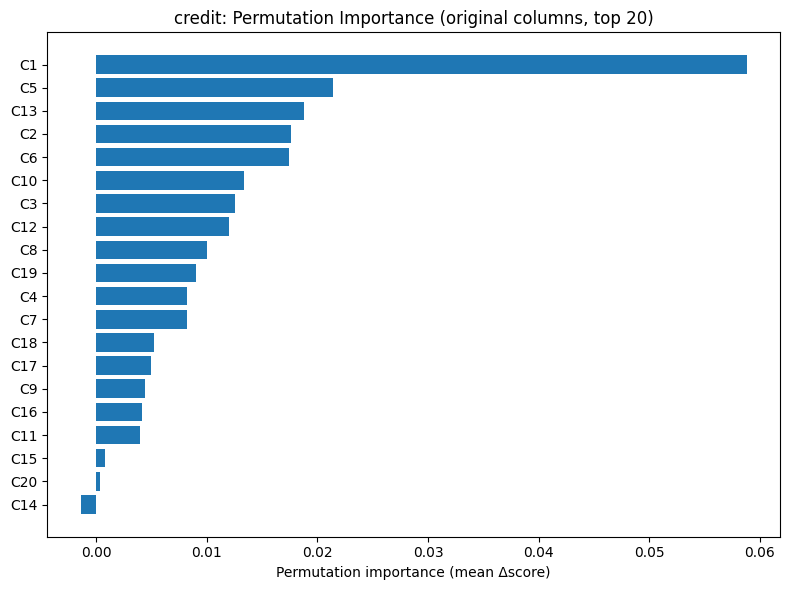

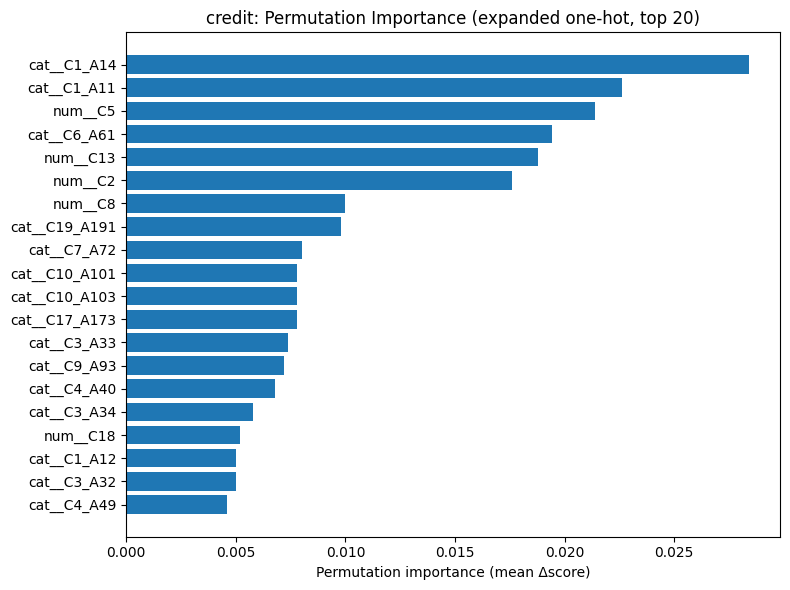

[credit] Saved:
- results/credit_perm_importance_AGG.csv
- results/credit_perm_importance_AGG.png
- results/credit_perm_importance_EXP.csv
- results/credit_perm_importance_EXP.png


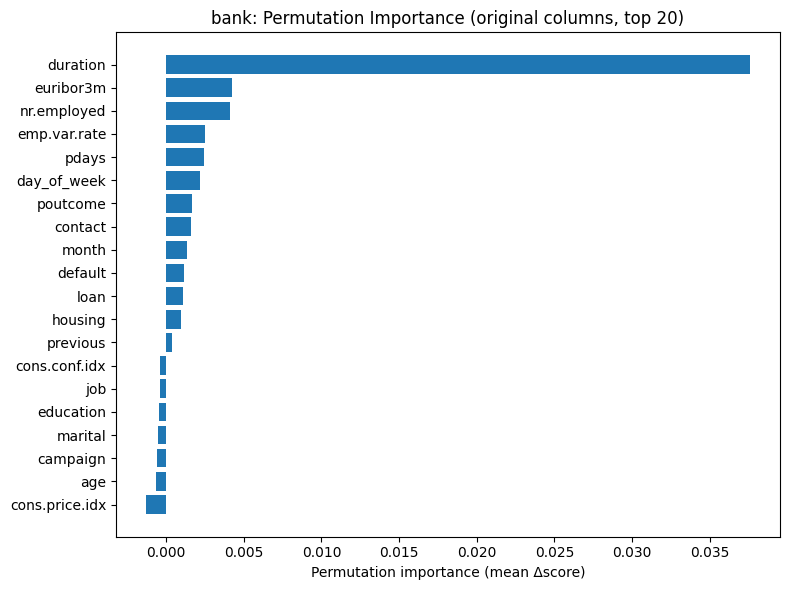

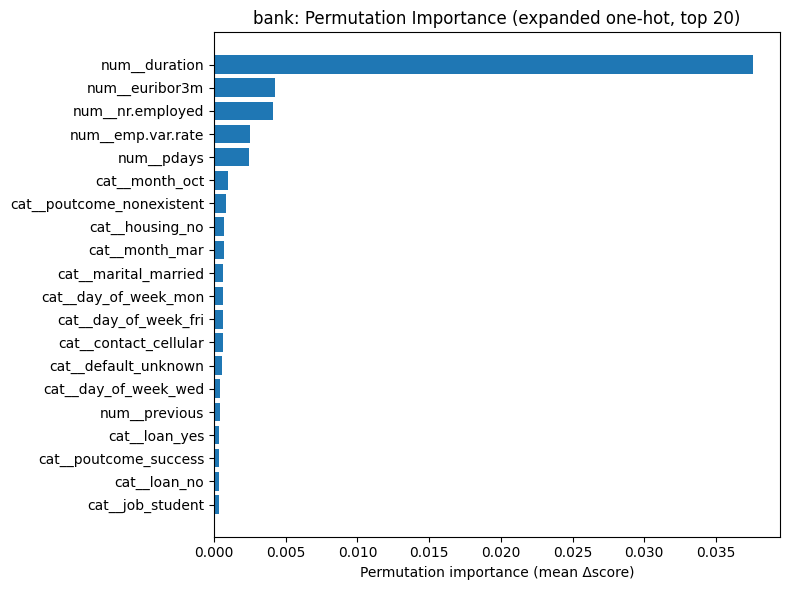

[bank] Saved:
- results/bank_perm_importance_AGG.csv
- results/bank_perm_importance_AGG.png
- results/bank_perm_importance_EXP.csv
- results/bank_perm_importance_EXP.png


,feature,importance
0,C1,0.0588
4,C5,0.0214
12,C13,0.0188
1,C2,0.0176
5,C6,0.0174
9,C10,0.0134
2,C3,0.0126
11,C12,0.0120
7,C8,0.0100
18,C19,0.0090


,feature,importance
10,duration,0.037584
18,euribor3m,0.004263
19,nr.employed,0.004113
15,emp.var.rate,0.002491
12,pdays,0.002428
9,day_of_week,0.002200
14,poutcome,0.001656
7,contact,0.001627
8,month,0.001340
4,default,0.001151


In [20]:
# Step 15
# === Step 12 (fixed): Permutation Feature Importance — Aggregated (original cols) + Expanded (one-hot) ===
# Assumes you have: credit_df, bank_df, preprocess_credit, preprocess_bank, RESULTS_DIR (Path("results"))

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

def _train_test_split_df(df, target_col, map_y=None, test_size=0.25):
    y = df[target_col]
    if map_y is not None:
        y = y.astype(str).str.strip().map(map_y).astype(int)
    X = df.drop(columns=[target_col])
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    return X_tr, X_te, y_tr, y_te

def _plot_barh(df, feat_col, val_col, title, out_png, top_n=20):
    top = df.sort_values(val_col, ascending=False).head(top_n)
    plt.figure(figsize=(8, 6))
    plt.barh(top[feat_col][::-1], top[val_col][::-1])
    plt.xlabel("Permutation importance (mean Δscore)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.show()

def run_perm_both_views(name, df, target_col, preprocessor, map_y=None):
    # 1) split once
    X_tr, X_te, y_tr, y_te = _train_test_split_df(df, target_col, map_y)

    # ---------- A) Aggregated (original columns): permutation on the Pipeline ----------
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
    ])
    pipe.fit(X_tr, y_tr)

    r_agg = permutation_importance(
        pipe, X_te, y_te, n_repeats=20, random_state=42, n_jobs=-1
    )
    agg_df = pd.DataFrame({
        "feature": X_te.columns,                  # one importance per ORIGINAL column
        "importance": r_agg.importances_mean
    }).sort_values("importance", ascending=False)

    agg_csv = RESULTS_DIR / f"{name}_perm_importance_AGG.csv"
    agg_png = RESULTS_DIR / f"{name}_perm_importance_AGG.png"
    agg_df.to_csv(agg_csv, index=False)
    _plot_barh(agg_df, "feature", "importance",
               f"{name}: Permutation Importance (original columns, top 20)",
               agg_png, top_n=20)

    # ---------- B) Expanded (one-hot dummies): fit preprocessor separately, then RF on transformed X ----------
    # Fit the preprocessor alone on TRAIN, transform TRAIN/TEST
    prep = preprocessor
    prep.fit(X_tr)
    Xtr_enc = prep.transform(X_tr)
    Xte_enc = prep.transform(X_te)

    # Get expanded feature names
    try:
        expanded_names = list(prep.get_feature_names_out())
    except Exception:
        # Fallback generic names
        expanded_names = [f"f{i}" for i in range(Xtr_enc.shape[1])]

    rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    rf.fit(Xtr_enc, y_tr)

    r_exp = permutation_importance(
        rf, Xte_enc, y_te, n_repeats=20, random_state=42, n_jobs=-1
    )
    exp_df = pd.DataFrame({
        "expanded_feature": expanded_names,       # one importance per DUMMY column
        "importance": r_exp.importances_mean
    }).sort_values("importance", ascending=False)

    exp_csv = RESULTS_DIR / f"{name}_perm_importance_EXP.csv"
    exp_png = RESULTS_DIR / f"{name}_perm_importance_EXP.png"
    exp_df.to_csv(exp_csv, index=False)
    _plot_barh(exp_df, "expanded_feature", "importance",
               f"{name}: Permutation Importance (expanded one-hot, top 20)",
               exp_png, top_n=20)

    print(f"[{name}] Saved:")
    print(f"- {agg_csv}")
    print(f"- {agg_png}")
    print(f"- {exp_csv}")
    print(f"- {exp_png}")
    return agg_df, exp_df

# ---------- CREDIT ----------
# Change target_col if your credit target isn’t named "target"
credit_agg, credit_exp = run_perm_both_views(
    name="credit",
    df=credit_df.copy(),
    target_col="target",
    preprocessor=preprocess_credit,
    map_y=None  # already numeric in your setup
)

# ---------- BANK ----------
bank_agg, bank_exp = run_perm_both_views(
    name="bank",
    df=bank_df.copy(),
    target_col="y",
    preprocessor=preprocess_bank,
    map_y={"no": 0, "yes": 1, "0": 0, "1": 1}
)

# Quick peek for the write-up (top-10 aggregated)
display(credit_agg.head(10))
display(bank_agg.head(10))




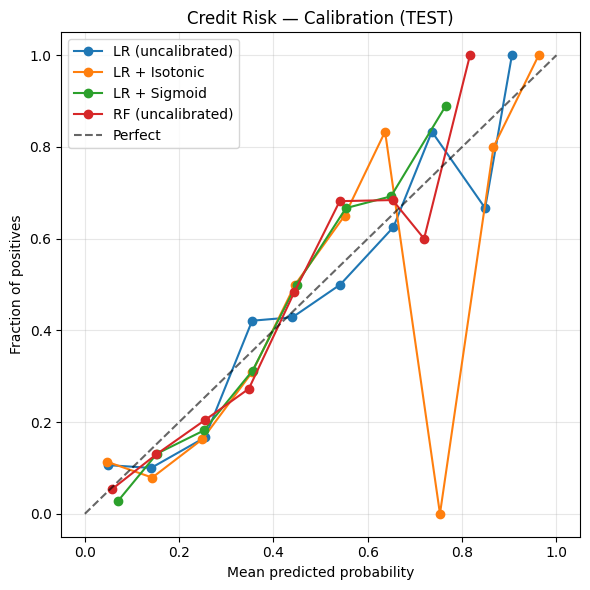

Saved: results/credit_calibration.png


,dataset,variant,brier,roc_auc,avg_precision
0,Credit Risk,lr_uncalibrated,0.155982,0.804267,0.650842
2,Credit Risk,lr_sigmoid,0.157097,0.805486,0.657833
1,Credit Risk,lr_isotonic,0.159576,0.800914,0.655262
3,Credit Risk,rf_uncalibrated,0.163430,0.794171,0.602718


Saved: results/credit_calibration_metrics.csv


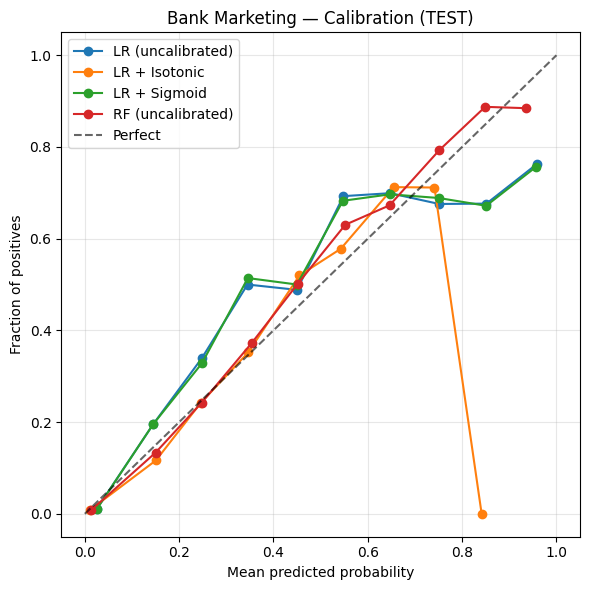

Saved: results/bank_calibration.png


,dataset,variant,brier,roc_auc,avg_precision
3,Bank Marketing,rf_uncalibrated,0.055726,0.946554,0.670224
1,Bank Marketing,lr_isotonic,0.058239,0.942258,0.622466
2,Bank Marketing,lr_sigmoid,0.060573,0.942251,0.623669
0,Bank Marketing,lr_uncalibrated,0.060600,0.942253,0.623388


Saved: results/bank_calibration_metrics.csv


In [22]:
# Step 16
# === Step 13: Probability Calibration (Credit & Bank) ===
# - Train/test split for each dataset
# - Compare Uncalibrated vs Isotonic vs Sigmoid (Platt)
# - Save reliability plots + CSV metrics

import numpy as np, pandas as pd, pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score

RESULTS_DIR = pathlib.Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

def make_preprocessor(X):
    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc", StandardScaler())]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ]
    )

def _proba_for_pos_label(pipe, X, pos_label):
    """Return P(y==pos_label). Handles label sets like {1,2} by locating the correct column."""
    proba = pipe.predict_proba(X)
    classes = list(pipe.classes_)
    idx = classes.index(pos_label)  # raises if pos_label not present -> useful error
    return proba[:, idx]

def run_calibration_block(dataset_name, X, y, pos_label, out_png, out_csv):
    """
    Fits base LR and RF; plots reliability (uncalibrated vs isotonic vs sigmoid) for LR;
    saves plot + CSV with Brier/ROC-AUC/AP for all variants.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    pre = make_preprocessor(X)

    # Base models
    lr = Pipeline([("prep", pre), ("clf", LogisticRegression(max_iter=2000))])
    rf = Pipeline([("prep", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])

    # --- Fit uncalibrated LR
    lr.fit(X_tr, y_tr)
    p_lr_tr = _proba_for_pos_label(lr, X_tr, pos_label)
    p_lr_te = _proba_for_pos_label(lr, X_te, pos_label)

    # --- Calibrated versions of LR
    lr_iso = Pipeline([("prep", pre),
                       ("clf", CalibratedClassifierCV(LogisticRegression(max_iter=2000), method="isotonic", cv=3))])
    lr_iso.fit(X_tr, y_tr)
    p_iso_te = _proba_for_pos_label(lr_iso, X_te, pos_label)

    lr_sig = Pipeline([("prep", pre),
                       ("clf", CalibratedClassifierCV(LogisticRegression(max_iter=2000), method="sigmoid", cv=3))])
    lr_sig.fit(X_tr, y_tr)
    p_sig_te = _proba_for_pos_label(lr_sig, X_te, pos_label)

    # --- RF (often reasonably calibrated with many trees, but include for comparison)
    rf.fit(X_tr, y_tr)
    p_rf_te = _proba_for_pos_label(rf, X_te, pos_label)

    # --- Reliability curves (TEST)
    plt.figure(figsize=(6,6))
    for label, p in [
        ("LR (uncalibrated)", p_lr_te),
        ("LR + Isotonic",     p_iso_te),
        ("LR + Sigmoid",      p_sig_te),
        ("RF (uncalibrated)", p_rf_te),
    ]:
        frac_pos, mean_pred = calibration_curve(y_te, p, n_bins=10, strategy="uniform", pos_label=pos_label)
        plt.plot(mean_pred, frac_pos, marker="o", label=label)

    plt.plot([0,1],[0,1], "k--", alpha=0.6, label="Perfect")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"{dataset_name} — Calibration (TEST)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"Saved: {out_png}")

    # --- Numeric metrics on TEST
    rows = []
    for name, p in [
        ("lr_uncalibrated", p_lr_te),
        ("lr_isotonic",     p_iso_te),
        ("lr_sigmoid",      p_sig_te),
        ("rf_uncalibrated", p_rf_te),
    ]:
        rows.append({
            "dataset": dataset_name,
            "variant": name,
            "brier": float(brier_score_loss(y_te == pos_label, p)),  # convert to boolean target for Brier
            "roc_auc": float(roc_auc_score((y_te == pos_label).astype(int), p)),
            "avg_precision": float(average_precision_score((y_te == pos_label).astype(int), p)),
        })
    df = pd.DataFrame(rows).sort_values("brier")
    display(df)
    df.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}")

# ---------- CREDIT (labels {1,2} -> choose positive class explicitly) ----------
X_credit = credit_df.drop(columns=["target"])
y_credit = credit_df["target"].astype(int)
run_calibration_block(
    dataset_name="Credit Risk",
    X=X_credit, y=y_credit,
    pos_label=2,  # << important: your positive class is 2
    out_png=RESULTS_DIR / "credit_calibration.png",
    out_csv=RESULTS_DIR / "credit_calibration_metrics.csv"
)

# ---------- BANK (mapped to 0/1 -> positive=1) ----------
X_bank = bank_df.drop(columns=["y"])
y_bank = bank_df["y"].astype(str).str.strip().map({"no":0, "yes":1}).astype(int)
run_calibration_block(
    dataset_name="Bank Marketing",
    X=X_bank, y=y_bank,
    pos_label=1,
    out_png=RESULTS_DIR / "bank_calibration.png",
    out_csv=RESULTS_DIR / "bank_calibration_metrics.csv"
)
